In [ ]:
import keras
from keras.layers.core import Activation, Dense
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score
import numpy as np
import json
from loaddata import word_emb
from scipy.stats import pearsonr
import random
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'


In [ ]:
embedding = word_emb()

with open('data.json', 'r', encoding='utf-8') as f:
    d = json.load(f)
    f.close()

with open('valid.json', 'r', encoding='utf-8') as f:
    vd = json.load(f)
    f.close()

In [ ]:
max_len = len(d['labeldata'])
indexlist = [i for i in range(max_len)]

SHUFFLE = True
if SHUFFLE:
    random.shuffle(indexlist)

Xtrain = []
ytrain = []
for indx in indexlist:
    Xtrain.append(d['textdata'][indx])
    ytrain.append(d['ce'][indx])

Xtest = []
ytest = []

for idx in range(len(vd['labeldata'])):
    Xtest.append(vd['textdata'][idx])
    ytest.append(vd['ce'][idx])

Xtrain = np.array(Xtrain)
Xtest = np.array(Xtest)


ytrain = to_categorical(ytrain, 8)
ytest = to_categorical(ytest, 8)

ite = np.array(embedding.ite)

EMBEDDING_SIZE = 300
HIDDEN_LAYER_SIZE = 100
vocab_size = 318049

In [12]:
checkpointer = ModelCheckpoint(
    filepath="weights-0.5drop.hdf5", verbose=1, save_best_only=True, mode='min')
w = embedding.ite
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=1500,
                    weights=[ite], mask_zero=True, trainable=False))
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(8, activation='sigmoid'))

# TEST
# model.load_weights(filepath="weights-0.5drop.hdf5")
ada = optimizers.Adam(lr=0.001)
model.compile(loss="categorical_crossentropy",
              optimizer=ada, metrics=["accuracy"])

BATCH_SIZE = 128
NUM_EPOCHS = 25
# keras.utils.plot_model(model,to_file='model.png',show_shapes=True,show_layer_names=True)
H = model.fit(Xtrain, ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
              validation_split=0.1, shuffle=False, callbacks=[checkpointer])

# 之前每次测试为300轮, 最后一次为了绘制局部结果，120 EPOCH 中断

Train on 2107 samples, validate on 235 samples
Epoch 1/200
2107/2107 [==============================] - 34s 16ms/step - loss: 1.8431 - accuracy: 0.3935 - val_loss: 1.7968 - val_accuracy: 0.3745

Epoch 00001: val_loss improved from inf to 1.79684, saving model to weights-0.5drop.hdf5
Epoch 2/200
2107/2107 [==============================] - 34s 16ms/step - loss: 1.6792 - accuracy: 0.4252 - val_loss: 1.7708 - val_accuracy: 0.3745

Epoch 00002: val_loss improved from 1.79684 to 1.77078, saving model to weights-0.5drop.hdf5
Epoch 3/200
2107/2107 [==============================] - 33s 16ms/step - loss: 1.6566 - accuracy: 0.4252 - val_loss: 1.7741 - val_accuracy: 0.3745

Epoch 00003: val_loss did not improve from 1.77078
Epoch 4/200
2107/2107 [==============================] - 33s 16ms/step - loss: 1.6407 - accuracy: 0.4252 - val_loss: 1.7719 - val_accuracy: 0.3745

Epoch 00004: val_loss did not improve from 1.77078
Epoch 5/200
2107/2107 [==============================] - 34s 16ms/step - loss

2107/2107 [==============================] - 38s 18ms/step - loss: 0.7860 - accuracy: 0.7385 - val_loss: 1.9004 - val_accuracy: 0.4638

Epoch 00081: val_loss did not improve from 1.75601
Epoch 82/200
2107/2107 [==============================] - 34s 16ms/step - loss: 0.7889 - accuracy: 0.7271 - val_loss: 1.8812 - val_accuracy: 0.4468

Epoch 00082: val_loss did not improve from 1.75601
Epoch 83/200
2107/2107 [==============================] - 34s 16ms/step - loss: 0.7660 - accuracy: 0.7347 - val_loss: 1.8833 - val_accuracy: 0.4383

Epoch 00083: val_loss did not improve from 1.75601
Epoch 84/200
2107/2107 [==============================] - 34s 16ms/step - loss: 0.7667 - accuracy: 0.7385 - val_loss: 1.9191 - val_accuracy: 0.4553

Epoch 00084: val_loss did not improve from 1.75601
Epoch 85/200
2107/2107 [==============================] - 37s 17ms/step - loss: 0.7546 - accuracy: 0.7413 - val_loss: 1.9016 - val_accuracy: 0.4213

Epoch 00085: val_loss did not improve from 1.75601
Epoch 86/200


KeyboardInterrupt: 

In [ ]:
# FOR TEST
predict = model.predict(Xtest)
pred = np.argmax(predict, axis=1)
total = 0
correct = 0
coef = 0
v = np.array(vd['ce'])
fscore = f1_score(v, pred, average='macro')
print(v)
print(pred)
for indx in range(len(pred)):
    total += 1
    v0 = np.array(vd['labeldata'][indx][1:])
    c = pearsonr(predict[indx], v0)
    coef += c[0]
    if ytest[indx][pred[indx]] == 1:
        correct += 1
print('acc:', correct/total, 'coef:', coef/total, 'Fscore:', fscore)

In [3]:
for k in H.history:
    print(k, H.history[k])

val_loss [1.740491956852852, 1.742436981201172, 1.7360920434302471, 1.7351306671791888, 1.7375644024382246, 1.7346269480725551, 1.7344638099061682, 1.733435292446867, 1.737139703872356, 1.7352054585801795, 1.7308669587399097, 1.7379500444899214, 1.7292856551231222, 1.7300701780522123, 1.732078253969233, 1.7252329714754795, 1.7325939523412826, 1.7483040748758518, 1.7602844679609257, 1.7371884599645087, 1.728251995431616, 1.7337486601890402, 1.7329128747290754, 1.7422695616458326, 1.744266599797188, 1.7483616478899693, 1.7510947455751136, 1.7483436787382085, 1.7627370387949841, 1.7759844374149403, 1.7585992858764974, 1.76676643909292, 1.7735337257385253, 1.7809884989515263, 1.7697699252595294, 1.7734879716913752, 1.7706993016790837, 1.7771478967463716, 1.7590721815190418, 1.768453158723547, 1.7639707387761867, 1.7762953230675231, 1.771064319509141, 1.799030370407916, 1.792334579914174, 1.793755633780297, 1.77884040842665, 1.76811623116757, 1.7684549686756539, 1.7735287138756286, 1.770345

In [4]:
train_loss_list = H.history['loss']
train_acc_list = H.history['accuracy']
test_loss_list = H.history['val_loss']
test_acc_list = H.history['val_accuracy']

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def paint(name, color='blue'):
    val0 = eval(name + '_list')
    vals = [i * 1.15 for i in val0]
    leng = len(vals)
    x_axis = list(range(len(vals)))
    plt.figure(figsize=(12.8, 9.6))
    plt.xlim(0, np.max(x_axis) * 1.1)
    plt.ylim(0, np.max(vals) * 1.1)
    plt.xlabel('epoch')
    plt.ylabel('value')
    plt.text(x=np.max(x_axis) * 0.3, y=np.max(vals) * 0.9, s=name + '_curve', fontsize=20)
    plt.plot(x_axis, vals, label=name, color=color)
    # plt.plot(x_axis, test_ratio_list, label='test_loss')
    plt.legend()
    plt.savefig('rnn_{}{}.png'.format(name, leng))

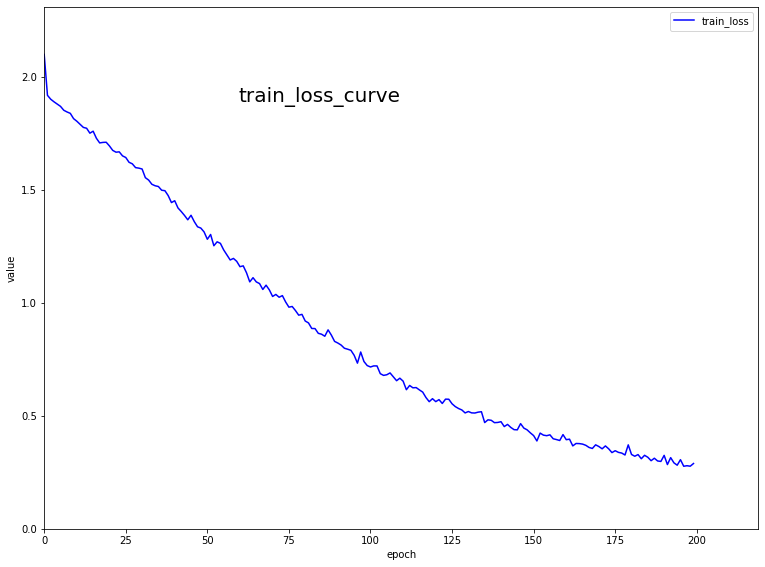

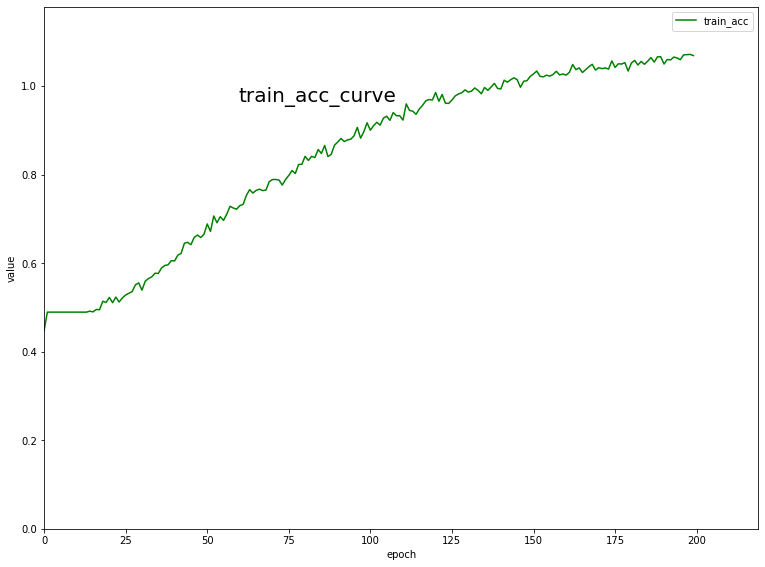

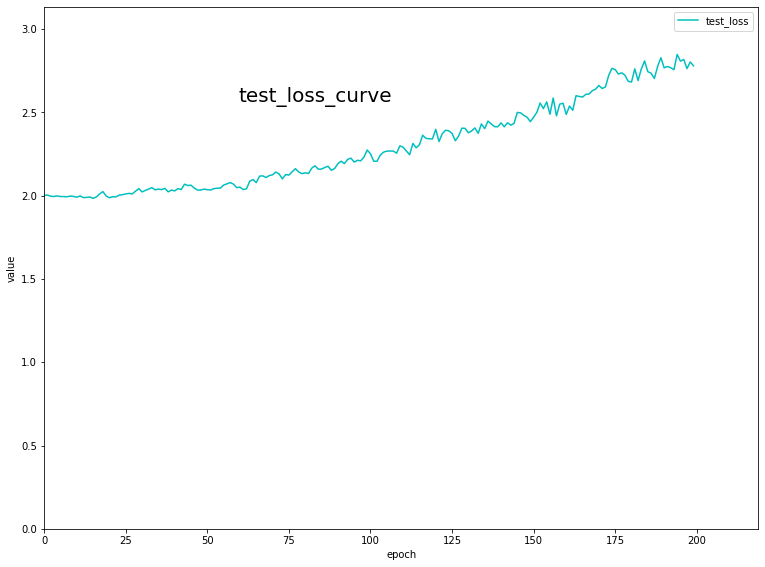

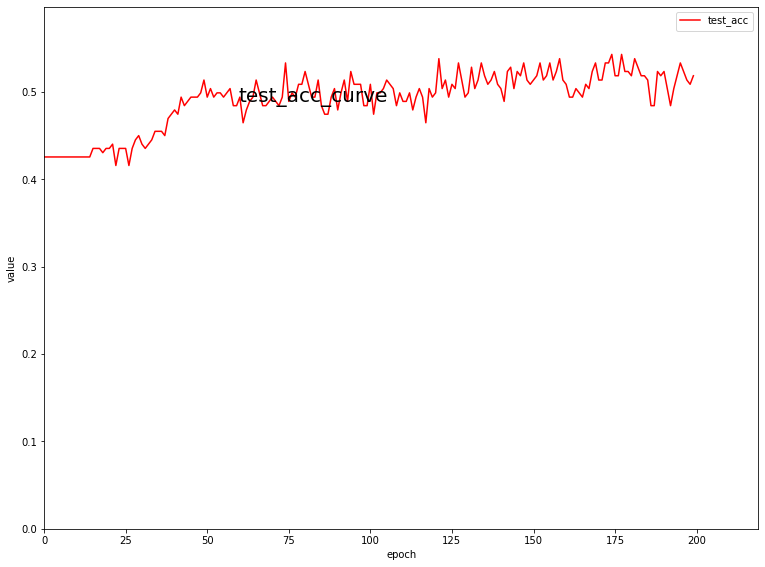

In [16]:
paint('train_loss', 'b')
paint('train_acc', 'g')
paint('test_loss', 'c')
paint('test_acc', 'r')

In [9]:
# np.savetxt("rnnlog.txt", [train_loss_list, train_acc_list, test_loss_list, test_acc_list])